In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from bgflow import IterativeSampler, SamplerStep, MCMCStep, SamplerState, GaussianProposal
import tqdm
from bgflow import LennardJonesPotential
from bgflow import  IterativeSampler, SamplerState, MCMCStep

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [11]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles
T = 0.5

from src.energies.lennardjones_energy import LennardJonesEnergy, lennard_jones_energy_torch
target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/test_split_LJ13-1000.npy",
    data_path_train= "../../data/train_split_LJ13-1000.npy",
    data_path_val= "../../data/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=T
    )

In [12]:
a = target.test_set[:1000]
target(a).mean()

tensor(86.6709, device='cuda:0')

In [14]:
a.shape

torch.Size([1000, 39])

In [15]:
# load numpy data
samples = np.load(f"/home/mila/t/tara.akhoundsadegh//scratch/lj13_samples/samples_v4_{T}_45.npy")
samples_2 = np.load(f"/home/mila/t/tara.akhoundsadegh//scratch/lj13_samples/samples_v4_{T}_32.npy")

samples= np.concatenate([samples, samples_2], axis=0)

In [16]:
samples = torch.tensor(samples, dtype=torch.float32).to(device)
samples = samples.view(-1, 39)

In [20]:
target(samples).mean()

target(samples).std()

tensor(6.9072, device='cuda:0')

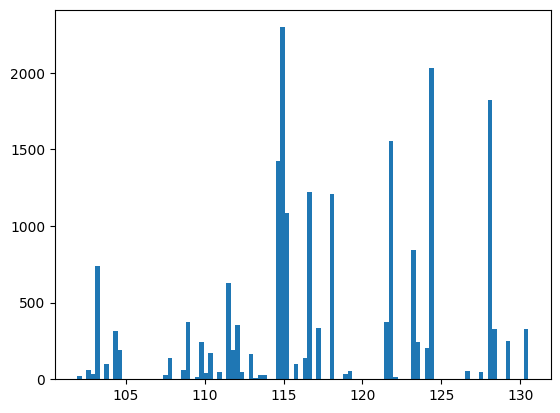

In [17]:
plt.hist(target(samples).detach().cpu().numpy(), bins=100);

/home/mila/t/tara.akhoundsadegh/scratch/demenv/lib/python3.10/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


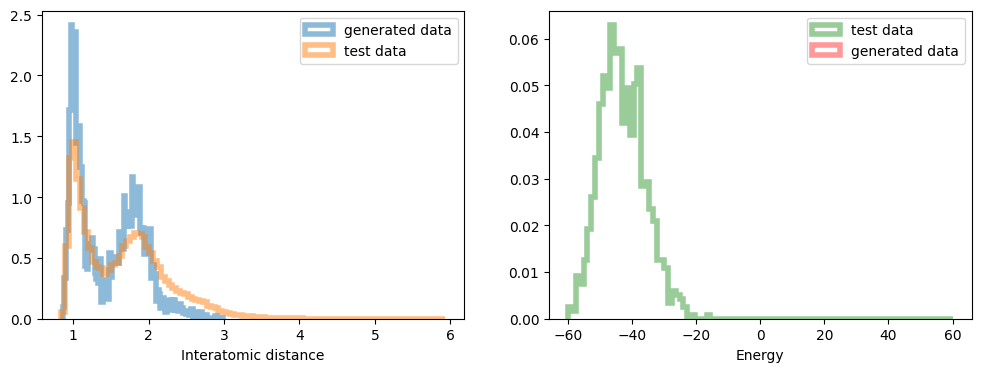

In [18]:
target.get_dataset_fig(samples, T=1.0, T_og=T);

In [25]:
from src.energies.lennardjones_energy import LennardJonesPotential

energy = LennardJonesPotential(dim=39, n_particles=13, two_event_dims=True)

n_chains = 1000
n_burnin = 200000

sampler_state = SamplerState(samples=[torch.randn(n_chains, 1, 13, 3)])
mcmc_step = MCMCStep(energy,
                     proposal=GaussianProposal(noise_std=0.1),
                     target_temperatures=1.0)
sampler = IterativeSampler(sampler_state,
                           sampler_steps=[mcmc_step],
                           stride=100,
                           n_burnin=n_burnin,
                           progress_bar=tqdm.tqdm,
                           return_hook=lambda samples: [samples[0][:,0]])

  0%|          | 0/200000 [00:15<?, ?it/s]


KeyboardInterrupt: 